# Notebook 03: Feature Engineering

**Prueba Técnica - Modelador Junior**

---

## Objetivo

Crear features avanzadas a partir de las predicciones de los 5 modelos:
1. Features básicas por modelo: cambios, direcciones
2. Features agregadas: media, mediana, desv. std
3. Features de consenso: acuerdo entre modelos
4. Features de dispersión: variabilidad de predicciones

---

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(42)

print("Librerías cargadas")

Librerías cargadas


## 2. Cargar Dataset Procesado

In [2]:
# Cargar dataset del notebook anterior
df = pd.read_csv('../data/processed/dataset_completo.csv')

# Convertir fechas
df['date_requested'] = pd.to_datetime(df['date_requested'])
df['date_prediction'] = pd.to_datetime(df['date_prediction'])

print(f"Dataset cargado: {df.shape}")
print(f"{list(df.columns)}")
display(df.head())

Dataset cargado: (56, 8)
['date_requested', 'date_prediction', 'value_at_request', 'value_at_prediction', 'direction_real', 'AA6KBD', 'IPBG4J', 'OBONV1']


,date_requested,date_prediction,value_at_request,value_at_prediction,direction_real,AA6KBD,IPBG4J,OBONV1
0,2024-03-07,2024-04-04,212.539897,229.151629,1,357.438293,362.087507,488.738378
1,2024-03-14,2024-04-11,222.152215,256.599110,1,357.438293,362.087507,265.336645
2,2024-03-21,2024-04-18,277.409972,377.644728,1,357.438293,362.087507,394.036593
3,2024-03-28,2024-04-25,237.324075,334.578301,1,357.438293,362.087507,319.777665
4,2024-04-04,2024-05-02,229.151629,304.996921,1,357.438293,362.087507,277.921764


## 3. Definir Modelos

In [3]:
# Lista de modelos
models = ['AA6KBD', 'IPBG4J', 'OBONV1']
print(f"Modelos: {models}")
display(df[models].describe())

Modelos: ['AA6KBD', 'IPBG4J', 'OBONV1']


,AA6KBD,IPBG4J,OBONV1
count,56.000000,56.000000,56.000000
mean,355.127620,359.691220,351.776395
std,56.047451,78.584131,87.332597
min,219.504748,201.665642,207.775661
25%,318.801899,314.965154,270.502771
50%,357.438293,362.087507,353.539727
75%,389.214319,410.224704,430.515190
max,456.483695,497.533229,495.225136


## 4. Features Básicas por Modelo

Para cada modelo, calcularemos:
- **Cambio absoluto**: predicción - precio_actual
- **Cambio porcentual**: (cambio / precio_actual) * 100
- **Dirección predicha**: 1 si predice subida, 0 si no

In [4]:
print("="*70)
print("CREANDO FEATURES POR MODELO")
print("="*70)

for model in models:
    # Cambio absoluto
    df[f'{model}_change'] = df[model] - df['value_at_request']
    
    # Cambio porcentual
    df[f'{model}_pct_change'] = (df[f'{model}_change'] / df['value_at_request']) * 100
    
    # Dirección predicha
    df[f'{model}_direction'] = (df[model] > df['value_at_request']).astype(int)

print(f"\nFeatures creadas: {len(models) * 3} features (3 por modelo)")
print(f"\nNuevas dimensiones: {df.shape}")

CREANDO FEATURES POR MODELO

Features creadas: 9 features (3 por modelo)

Nuevas dimensiones: (56, 17)


## 5. Features Agregadas

Estadísticas sobre el conjunto de predicciones:

In [5]:
print("\n" + "="*70)
print("CREANDO FEATURES AGREGADAS")
print("="*70)

# Media de predicciones
df['pred_mean'] = df[models].mean(axis=1)

# Mediana
df['pred_median'] = df[models].median(axis=1)

# Desviación estándar
df['pred_std'] = df[models].std(axis=1)

# Mínimo y máximo
df['pred_min'] = df[models].min(axis=1)
df['pred_max'] = df[models].max(axis=1)

# Rango
df['pred_range'] = df['pred_max'] - df['pred_min']

print(f"6 features agregadas creadas")
print(f"\nEstadísticas de features agregadas:")
display(df[['pred_mean', 'pred_median', 'pred_std', 'pred_range']].describe())


CREANDO FEATURES AGREGADAS
6 features agregadas creadas

Estadísticas de features agregadas:


,pred_mean,pred_median,pred_std,pred_range
count,56.000000,56.000000,56.000000,56.000000
mean,355.531745,356.125978,71.549969,133.715711
std,39.053234,51.370438,31.428370,59.218767
min,272.878200,226.854615,16.557436,30.465209
25%,325.615728,339.108100,48.308311,89.035727
50%,355.264096,357.438293,72.679950,133.415286
75%,383.161087,385.777860,97.101996,181.509863
max,459.656285,476.290658,134.464646,260.719182


## 6. Features de Consenso

¿Cuántos modelos están de acuerdo en la dirección?

In [6]:
print("\n" + "="*70)
print("CREANDO FEATURES DE CONSENSO")
print("="*70)

# Obtener columnas de dirección
direction_cols = [f'{model}_direction' for model in models]

# Consenso: dirección mayoritaria
df['consensus_direction'] = df[direction_cols].mode(axis=1)[0].astype(int)

# Cantidad de modelos bullish (predicen subida)
df['consensus_bullish'] = df[direction_cols].sum(axis=1)

# Cantidad de modelos bearish (predicen bajada)
df['consensus_bearish'] = len(models) - df['consensus_bullish']

# Hay empate?
df['consensus_mixed'] = (df['consensus_bullish'] == df['consensus_bearish']).astype(int)

# Grado de acuerdo (0 a 1)
df['direction_agreement'] = df[direction_cols].std(axis=1)

print(f"5 features de consenso creadas")
print(f"\nDistribución de consenso:")
print(df['consensus_direction'].value_counts())
print(f"\nDistribución de acuerdo:")
print(df.groupby('consensus_bullish').size())


CREANDO FEATURES DE CONSENSO
5 features de consenso creadas

Distribución de consenso:
consensus_direction
1    47
0     9
Name: count, dtype: int64

Distribución de acuerdo:
consensus_bullish
0     3
1     6
2    23
3    24
dtype: int64


## 7. Features de Dispersión

Medidas de variabilidad en las predicciones:

In [7]:
print("\n" + "="*70)
print("CREANDO FEATURES DE DISPERSIÓN")
print("="*70)

# Cambio promedio predicho
change_cols = [f'{model}_change' for model in models]
df['avg_change'] = df[change_cols].mean(axis=1)

# Cambio porcentual promedio
pct_change_cols = [f'{model}_pct_change' for model in models]
df['avg_pct_change'] = df[pct_change_cols].mean(axis=1)

# Desviación estándar de cambios
df['std_change'] = df[change_cols].std(axis=1)
df['std_pct_change'] = df[pct_change_cols].std(axis=1)

# Confianza de predicción (inversa de la dispersión)
df['prediction_confidence'] = 1 / (1 + df['pred_std'])

print(f"5 features de dispersión creadas")
print(f"\nEstadísticas de dispersión:")
display(df[['avg_change', 'avg_pct_change', 'std_change', 'prediction_confidence']].describe())


CREANDO FEATURES DE DISPERSIÓN
5 features de dispersión creadas

Estadísticas de dispersión:


,avg_change,avg_pct_change,std_change,prediction_confidence
count,56.000000,56.000000,56.000000,56.000000
mean,51.658204,21.165882,71.549969,0.018269
std,64.821342,26.289918,31.428370,0.012238
min,-99.386257,-26.697756,16.557436,0.007382
25%,1.599916,0.539715,48.308311,0.010193
50%,54.032581,18.900416,72.679950,0.013572
75%,91.868278,38.469099,97.101996,0.020283
max,190.214829,89.496058,134.464646,0.056956


## 8. Resumen de Features Creadas

In [8]:
print("\n" + "="*70)
print("RESUMEN DE FEATURE ENGINEERING")
print("="*70)

total_features = len(df.columns) - 5  # Menos las columnas originales
print(f"\nTotal de features creadas: {total_features}")
print(f"Dimensiones finales: {df.shape}")

print("\nCategorías de features:")
print(f"   • Features por modelo (cambio, %, dirección): {len(models) * 3}")
print(f"   • Features agregadas (mean, median, std, etc): 6")
print(f"   • Features de consenso (acuerdo, dirección): 5")
print(f"   • Features de dispersión (variabilidad): 5")
print(f"   • Total: {len(models) * 3 + 6 + 5 + 5} features")


RESUMEN DE FEATURE ENGINEERING

Total de features creadas: 28
Dimensiones finales: (56, 33)

Categorías de features:
   • Features por modelo (cambio, %, dirección): 9
   • Features agregadas (mean, median, std, etc): 6
   • Features de consenso (acuerdo, dirección): 5
   • Features de dispersión (variabilidad): 5
   • Total: 25 features


## 9. Análisis de Correlación con Variable Objetivo

In [9]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['date_requested', 'date_prediction']]

# Calcular correlación con variable objetivo
corr_with_target = df[numeric_cols].corrwith(df['direction_real']).sort_values(ascending=False)

print("\nTop 10 Features más correlacionadas con dirección real:")
print(corr_with_target.head(10))

print("\nBottom 10 Features (correlación negativa):")
print(corr_with_target.tail(10))


Top 10 Features más correlacionadas con dirección real:
direction_real         1.000000
avg_pct_change         0.610357
avg_change             0.602371
IPBG4J_pct_change      0.598261
IPBG4J_change          0.569129
value_at_prediction    0.557008
AA6KBD_pct_change      0.483980
AA6KBD_change          0.439740
consensus_bullish      0.423896
IPBG4J_direction       0.416667
dtype: float64

Bottom 10 Features (correlación negativa):
pred_range               0.078629
pred_median              0.072929
OBONV1_direction         0.034922
AA6KBD                  -0.015935
prediction_confidence   -0.063442
OBONV1                  -0.063894
direction_agreement     -0.319809
consensus_bearish       -0.423896
value_at_request        -0.575858
consensus_mixed               NaN
dtype: float64


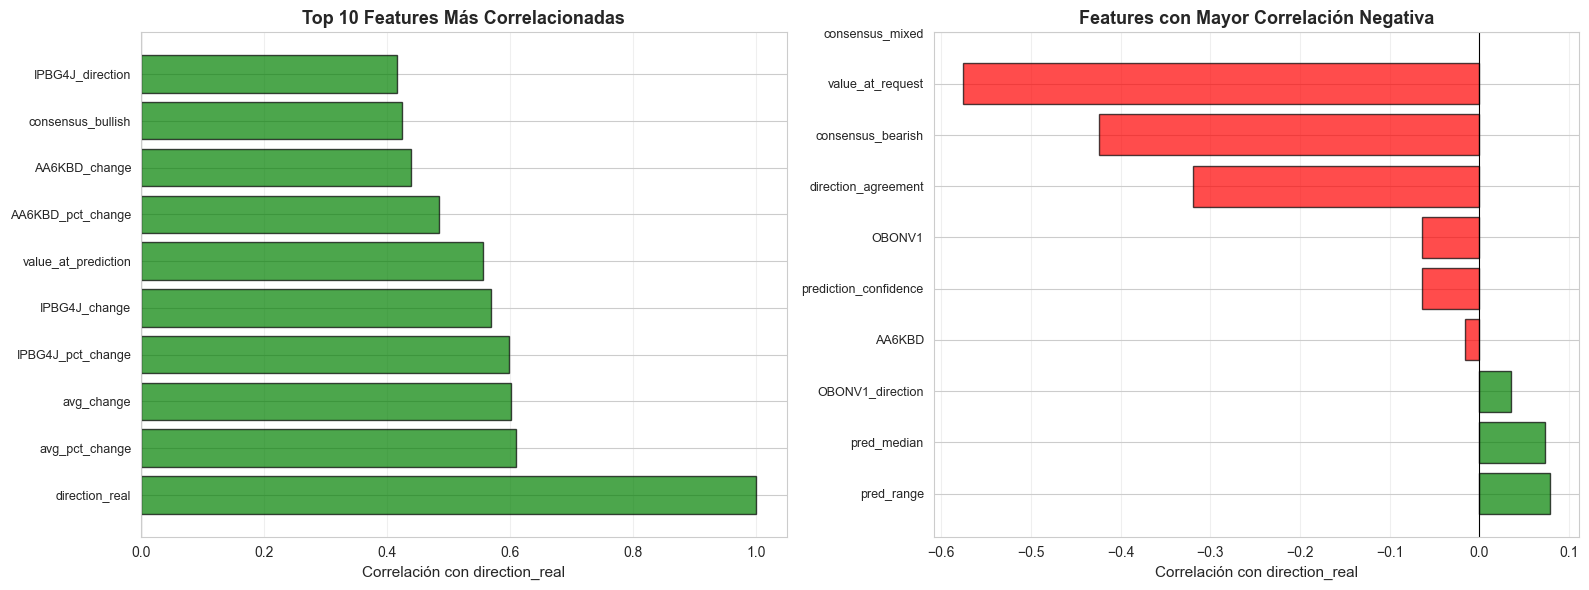


Grafico guardado


In [10]:
# Visualizar correlaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top features positivas
top_10 = corr_with_target.head(10)
colors_pos = ['green' if x > 0 else 'red' for x in top_10]
axes[0].barh(range(len(top_10)), top_10.values, color=colors_pos, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10.index, fontsize=9)
axes[0].set_title('Top 10 Features Más Correlacionadas', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Correlación con direction_real', fontsize=11)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].grid(True, alpha=0.3, axis='x')

# Bottom features negativas
bottom_10 = corr_with_target.tail(10)
colors_neg = ['green' if x > 0 else 'red' for x in bottom_10]
axes[1].barh(range(len(bottom_10)), bottom_10.values, color=colors_neg, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(bottom_10)))
axes[1].set_yticklabels(bottom_10.index, fontsize=9)
axes[1].set_title('Features con Mayor Correlación Negativa', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Correlación con direction_real', fontsize=11)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/figures/05_correlacion_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico guardado")

## 10. Guardar Dataset Final

In [11]:
# Guardar dataset con todas las features
output_file = '../data/processed/dataset_final.csv'
df.to_csv(output_file, index=False)

print("\n" + "="*70)
print("DATASET FINAL GUARDADO")
print("="*70)
print(f"\nArchivo: {output_file}")
print(f"Dimensiones: {df.shape}")
print(f"Total de features: {len(df.columns) - 5}")
print("\nDataset final guardado exitosamente")


DATASET FINAL GUARDADO

Archivo: ../data/processed/dataset_final.csv
Dimensiones: (56, 33)
Total de features: 28

Dataset final guardado exitosamente
